In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [3]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [4]:
def cuda_wrapper(torch_obj):
    if USE_CUDA:
        return torch_obj.cuda()
    else:
        return torch_obj

In [5]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [6]:
batch_size = 32

In [7]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

dataset = CIFAR10

train_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=False, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

Files already downloaded and verified


In [8]:
print(train_loader.dataset.train_data.shape)
print(test_loader.dataset.test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [9]:
class ModelFullyConnected(nn.Module):
    def __init__(self, input_shape, output_size, num_hidden=1, hidden_dim=200, nonlinearity=nn.ReLU):
        super(type(self), self).__init__()
        self.nonlinearity = nonlinearity()
        input_size = int(np.prod(np.array(input_shape, dtype=int)))
        self.input_layer = nn.Linear(input_size, hidden_dim)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.output_layer = nn.Linear(hidden_dim, output_size)
        
    def forward(self, X):
        Z = self.input_layer(X.view(X.size(0), -1))
        for layer in self.hidden_layers:
            Z = layer(self.nonlinearity(Z))
        return F.log_softmax(self.output_layer(self.nonlinearity(Z)), dim=1)

In [10]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size, 
        num_blocks=1, num_filters=16, filter_size=3, num_dense_units=256, 
        nonlinearity=nn.ReLU
    ):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2]
        shape = input_shape[1]
        in_channels = input_shape[0]
        out_channels = num_filters
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_blocks):
            self.hidden_layers.append(nn.Conv2d(in_channels, out_channels, filter_size))
            shape = shape - (filter_size - 1)
            self.hidden_layers.append(nonlinearity())
            in_channels, out_channels = out_channels, num_filters
            self.hidden_layers.append(nn.Conv2d(in_channels, out_channels, filter_size))
            shape = shape - (filter_size - 1)
            self.hidden_layers.append(nn.MaxPool2d(2))
            shape = shape // 2
            self.hidden_layers.append(nonlinearity())
            in_channels, out_channels = out_channels, num_filters

        #in_channels = num_filters * shape * shape
        #out_channels = num_dense_units
        self.output_layers = nn.ModuleList()
        self.output_layers.append(nn.Linear(num_filters * shape * shape, num_dense_units))
        self.output_layers.append(nonlinearity())
        self.output_layers.append(nn.Linear(num_dense_units, output_size))
        
    def forward(self, X):
        for layer in self.hidden_layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        for layer in self.output_layers:
            X = layer(X)
        return F.log_softmax(X, dim=1)

In [11]:
def symmetry_direction(X):
    # horizontal translation:
    return torch.cat((X[:, :, :, 1:], X[:, :, :, :1]), dim=-1) - torch.cat((X[:, :, :, -1:], X[:, :, :, :-1]), dim=-1)

In [12]:
def constrain_loss_function(model_output, model_input):
    # model_output: [batch_size x num_classes]
    # model_input: [batch_size x C x H x W]
    batch_size, num_classes = model_output.size()
    grad_output_wrt_input_for_each_class = []
    for output in torch.unbind(torch.sum(model_output, dim=0)):
        grad_output_wrt_input_for_each_class.append(
            autograd.grad([output], [model_input], create_graph=True)[0]
        ) # [batch_size x C x H x W]
    grad_output_wrt_input = torch.stack(grad_output_wrt_input_for_each_class) # [num_classes x batch_size x C x H x W]
    sym_dir = symmetry_direction(model_input) # [batch_size x C x H x W]
    return torch.sum((grad_output_wrt_input * sym_dir.view(1, *model_input.size())) ** 2) / batch_size

In [13]:
def random_input_generator(input_shape, batch_size):
    while True:
        # generate uniform noise:
        yield torch.rand(batch_size, *input_shape)

In [46]:
from time import time

num_epochs = 20

input_shape = train_loader.dataset.train_data.shape[1:]
input_shape = input_shape[-1:] + input_shape[:-1]
output_size = 10

eta_start = 0.1
eta_end = eta_start
eta_growth_factor = ((eta_end + 1e-8) / (eta_start + 1e-8)) ** (1 / num_epochs)

torch.manual_seed(123)
np.random.seed(123)
model = cuda_wrapper(ModelFullyConnected(input_shape, output_size, num_hidden=2, hidden_dim=3*32*32))
#model = cuda_wrapper(
#    ModelConvolutional(
#        input_shape, output_size, num_blocks=2, num_filters=32, filter_size=3, num_dense_units=512, nonlinearity=nn.ReLU
#    )
#)
optimizer = optim.Adam(model.parameters())
loss_function = nn.NLLLoss()

random_input_gen = random_input_generator(input_shape, batch_size)

for epoch in range(num_epochs):
    start_time = time()
    
    eta = eta_start * eta_growth_factor ** epoch
            
    cum_loss_data = 0
    cum_loss_constrain = 0
    cum_loss_full = 0
    batch_count = 0

    for X, y in train_loader:
        X, y = cuda_wrapper(Variable(X, requires_grad=True)), cuda_wrapper(Variable(y))
        prediction = model(X)
        loss_data = loss_function(prediction, y)
        cum_loss_data += loss_data.data[0]
        
        #X_random = cuda_wrapper(Variable(next(random_input_gen), requires_grad=True))
        #loss_constrain = constrain_loss_function(model(X_random), X_random)
        loss_constrain = constrain_loss_function(prediction, X)
        cum_loss_constrain += loss_constrain.data[0]
        
        loss_full = loss_data + eta * loss_constrain
        #loss_full = loss_data
        cum_loss_full += loss_full.data[0]
            
        optimizer.zero_grad()
        loss_full.backward()
        optimizer.step()
        batch_count += 1
            
    mean_train_loss_data = cum_loss_data / batch_count
    mean_train_loss_constrain = cum_loss_constrain / batch_count
    mean_train_loss_full = cum_loss_full / batch_count

    cum_loss_data = 0
    cum_loss_constrain = 0
    batch_count = 0

    for X, y in test_loader:
        X, y = cuda_wrapper(Variable(X, requires_grad=True)), cuda_wrapper(Variable(y))
        prediction = model(X)
        loss_data = loss_function(prediction, y)
        cum_loss_data += loss_data.data[0]
        
        loss_constrain = constrain_loss_function(prediction, X)
        cum_loss_constrain += loss_constrain.data[0]
        
        batch_count += 1
            
    mean_test_loss_data = cum_loss_data / batch_count
    mean_test_loss_constrain = cum_loss_constrain / batch_count

    print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
    print('train loss:')
    print(
        'data term: {:.2f}, constrain term: {:.2f}, full: {:.2f}'.format(
            mean_train_loss_data, mean_train_loss_constrain, mean_train_loss_full
        )
    )
    print('test loss:')
    print(
        'data term: {:.2f}, constrain term: {:.2f}'.format(
            mean_test_loss_data, mean_test_loss_constrain
        )
    )
    print('eta = {:.3f}'.format(eta))
    print()


Epoch 1 of 20 took 108.18s;
train loss:
data term: 1.91, constrain term: 0.08, full: 1.92
test loss:
data term: 1.82, constrain term: 0.11
eta = 0.100

Epoch 2 of 20 took 108.12s;
train loss:
data term: 1.74, constrain term: 0.14, full: 1.75
test loss:
data term: 1.71, constrain term: 0.15
eta = 0.100

Epoch 3 of 20 took 107.76s;
train loss:
data term: 1.67, constrain term: 0.19, full: 1.69
test loss:
data term: 1.62, constrain term: 0.19
eta = 0.100

Epoch 4 of 20 took 107.64s;
train loss:
data term: 1.62, constrain term: 0.23, full: 1.64
test loss:
data term: 1.66, constrain term: 0.27
eta = 0.100

Epoch 5 of 20 took 107.64s;
train loss:
data term: 1.58, constrain term: 0.27, full: 1.60
test loss:
data term: 1.57, constrain term: 0.23
eta = 0.100

Epoch 6 of 20 took 107.58s;
train loss:
data term: 1.55, constrain term: 0.30, full: 1.58
test loss:
data term: 1.57, constrain term: 0.32
eta = 0.100

Epoch 7 of 20 took 107.66s;
train loss:
data term: 1.52, constrain term: 0.33, full: 1.5

In [ ]:
# CIFAR10. batch_size=32
# Constrain term uses log probability
# (<data term>, <constrain term>, <full>), <best test loss>

# ModelConvolutional(num_blocks=2, num_filters=16, filter_size=3, num_dense_units=256)
# Every 20 epochs:
# eta=0: {(0.61, 911.65, 0.61), 0.99}
# eta=0.001: {(0.71, 24.80, 0.73), 0.95}, {(0.51, 31.44, 0.55), 0.95}
# eta=0.01: {(0.89, 5.81, 0.95), 1.00}, {(0.75, 5.93, 0.80), 0.94}, {(0.68, 6.13, 0.74), 0.93}
# eta=0.1: {(1.24, 1.28, 1.36), 1.27}, {(1.16, 1.42, 1.31), 1.19}

# ModelConvolutional(num_blocks=2, num_filters=32, filter_size=3, num_dense_units=512)
# Every 20 epochs:
# eta=0: {(0.14, 5576.62, 0.14), 0.82}
# eta=0.001: {(0.16, 13.21, 0.18), 0.82}
# eta=0.01: {(0.36, 3.99, 0.40), 0.79}
# eta=0.1: {(1.00, 1.48, 1.15), 1.07}, {(0.90, 1.64, 1.06), 1.04}, {(0.83, 1.73, 1.00), 1.04}, {(0.90, 1.64, 1.06), 1.04}
# eta>0.01: {(0.60, 0.88, 0.68), 0.79} 0.1

# ModelConvolutional(num_blocks=2, num_filters=64, filter_size=3, num_dense_units=1024)
# Every 20 epochs:
# eta=0 {(0.09, 7343.33, 0.09), 0.84}
# eta=0.001 {(0.09, 6.85, 0.10), 0.82}
# eta=0.01 {(0.20, 4.61, 0.24), 0.78}
# eta=0.1 {(0.92, 1.48, 1.07), 1.04}, {(0.79, 1.74, 0.96), 1.02}
# eta=1 {(1.24, 0.18, 1.42), 1.29}, {(1.19, 0.20, 1.39), 1.26}, {(1.15, 0.21, 1.36), 1.24}

# ModelFullyConnected(num_hidden=1, hidden_dim=100)
# Every 20 epochs:
# eta=0: {(1.35, 11.97, 1.35), 1.45}, {(1.26, 23.60, 1.26), 1.42}
# eta=0.01: {(1.38, 3.83, 1.42), 1.43}, {(1.32, 4.87, 1.37), 1.40}, {(1.30, 5.40, 1.35), 1.41}, {(1.28, 5.90, 1.34), 1.40}
# eta=0.1: {(1.52, 0.89, 1.61), 1.51}, {(1.50, 0.95, 1.59), 1.49}, {(1.50, 0.95, 1.59), 1.49}, {(1.50, 0.95, 1.58), 1.48}

# ModelFullyConnected(num_hidden=2, hidden_dim=100)
# Every 20 epochs:
# eta=0: {(1.29, 15.48, 1.29), 1.43}, {(1.18, 37.30, 1.18), 1.43}


In [ ]:
# CIFAR10. batch_size=32
# Constrain term uses log probability
# (<data term>, <uniform constrain term>, <train data constrain term>, <full>), 
# (<best test loss>, <test data constrain term>)

# ModelConvolutional(num_blocks=2, num_filters=32, filter_size=3, num_dense_units=512)
# Every 20 epochs:
# eta=0: {(0.13, 5814.25, 845.06, 0.13), (0.86, 807.47)}
# optimizing uniform constrain term:
# eta=0.01: {(0.37, 4.83, ----, 0.42), (0.78, 31.16)}
# optimizing train data constrain term:
# eta=0.01: {(0.38, ----, 9.28, 0.47), (0.78, 9.86)}


In [ ]:
# CIFAR10. batch_size=32
# Constrain term uses log probability
# (<data term>, <uniform constrain term>, <train data constrain term>, <full>), 
# (<best test loss>, <test data constrain term>)

# ModelConvolutional(num_blocks=2, num_filters=32, filter_size=3, num_dense_units=512), 
# quadratic nonlinearity between convolutional and dense layers
# Every 20 epochs:
# eta=0: {(0.14, 7364.90, ----, 0.14), (0.94, 1019.71)}
# optimizing uniform constrain term:
# eta=0.01: {(0.14, 0.02, ----, 0.14), (0.85, 1301.14)}
# optimizing train data constrain term:
# eta=0.01: {(0.36, ----, 9.63, 0.46), (0.81, 8.42)}
# eta=0.1: {(0.67, ----, 1.29, 0.80), (0.88, 1.24)}


In [40]:
mean_distances = {}

In [47]:
mean_distances[eta_start] = []
num_symmetries = 32
for k in range(1, num_symmetries):
    distances = []
    for X, y in test_loader:
        batch_size = X.size(0)
        X = cuda_wrapper(Variable(X))
        X_transformed = torch.cat((X[:, :, :, k:], X[:, :, :, :k]), dim=-1)
        log_distr = model(X).data
        log_distr_transformed = model(X_transformed).data
        distance = 0.5 * torch.sum(
            (torch.exp(log_distr) - torch.exp(log_distr_transformed)) * (log_distr - log_distr_transformed)
        ) / batch_size
        distances.append(distance)
    
    mean_distances[eta_start].append(np.mean(np.array(distances)))

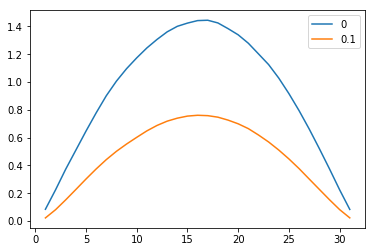

In [48]:
etas = [0, 0.1]

for eta in etas:
    plt.plot(range(1, num_symmetries), mean_distances[eta])
plt.legend(etas)

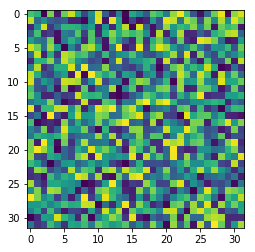

In [49]:
plt.imshow(model.input_layer.weight[100].view(3, 32, 32)[0].data.cpu().numpy())

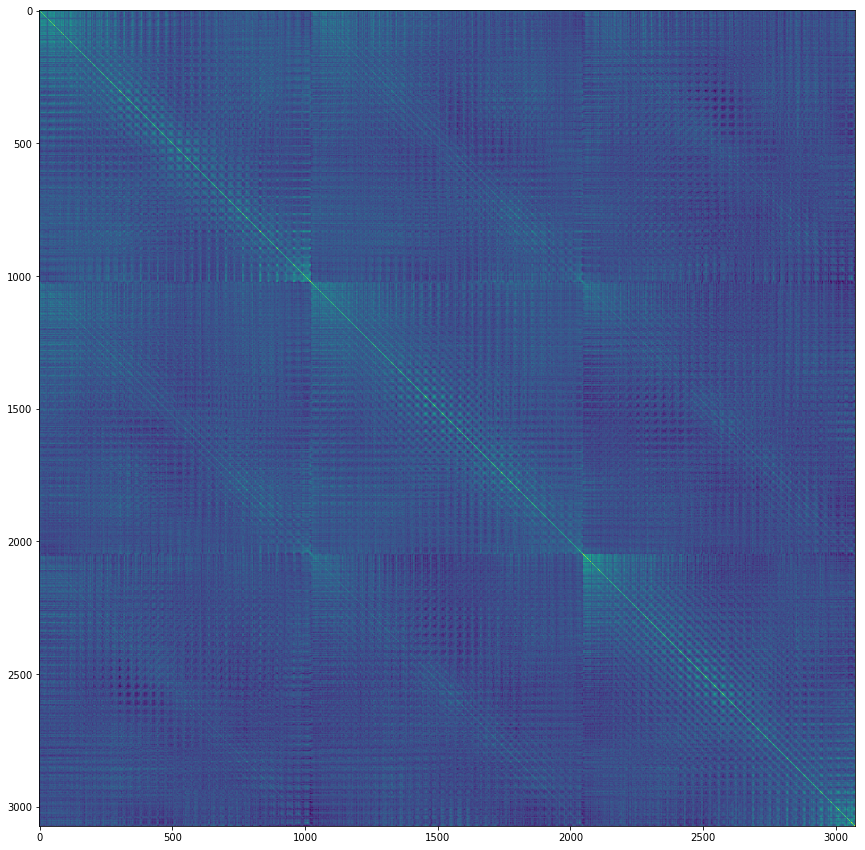

In [50]:
plt.figure(figsize=(15, 15))
plt.imshow((model.input_layer.weight.data.t() @ model.input_layer.weight.data).cpu().numpy())

In [45]:
model0_input_layer_weight = model.input_layer.weight.data.clone()

In [27]:
model0_input_layer_weight


-1.1592e-02 -3.5071e-03 -1.3084e-02  ...  -5.6109e-03  1.1439e-03 -7.4106e-04
-2.5763e-03  1.0346e-02 -1.0948e-02  ...   1.2902e-02  1.1110e-02 -1.7824e-02
-1.6446e-02  4.1521e-07 -1.4168e-02  ...  -6.5819e-03 -4.9697e-03  5.4409e-03
                ...                   ⋱                   ...                
-1.0975e-02 -5.3522e-03 -5.9618e-03  ...  -1.7890e-02  8.7403e-03  1.2518e-02
-2.0848e-02 -2.1314e-02  2.8885e-03  ...  -8.9723e-03 -1.3565e-02 -1.1951e-02
-2.3774e-02  4.6209e-03 -4.0415e-03  ...  -6.3221e-03 -2.6037e-02 -8.3744e-04
[torch.cuda.FloatTensor of size 3072x3072 (GPU 0)]